# AVCMI 20180106

In [28]:
# Import libraries

import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [22]:
# Import data

data = pd.read_csv('avcmi20180106', sep = '  ', header=None, engine='python')
data.columns = ['name','ID','airmass','filt','JD','mag_obs','mag_err']

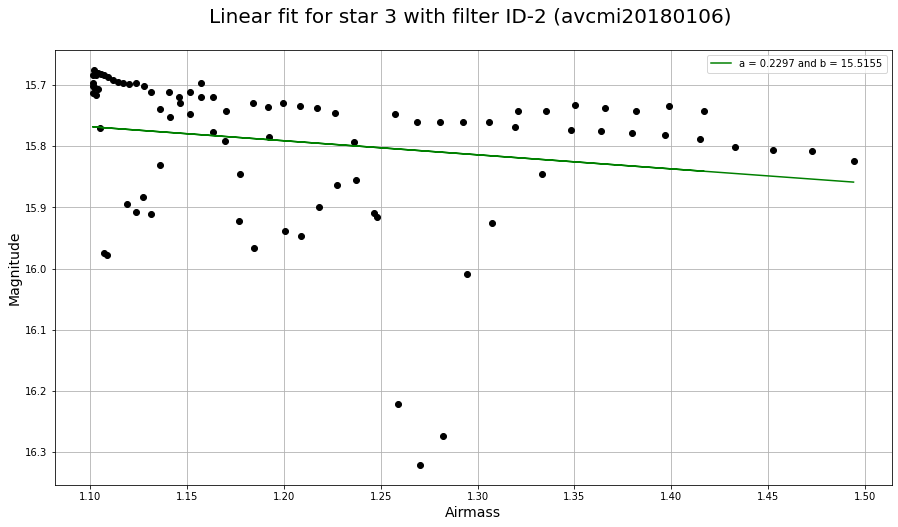

In [23]:
# Linear regression test

ID_1 = data['ID']
airmass_1 = data['airmass']
filt_1 = data['filt']
mag_obs_1 = data['mag_obs']

linear_regressor = LinearRegression()
linear_regressor.fit((airmass_1[(filt_1==2) & (ID_1==3)]).values.reshape(-1, 1), 
                     (mag_obs_1[(filt_1==2) & (ID_1==3)]).values.reshape(-1, 1))
y_pred = linear_regressor.predict((airmass_1[(filt_1==2) & (ID_1==3)]).values.reshape(-1, 1))

coefficients = np.polyfit(np.array(airmass_1[(filt_1==2) & (ID_1==3)]),
                          np.array(mag_obs_1[(filt_1==2) & (ID_1==3)]), 1)

plt.figure(figsize=(15,8))

plt.plot(np.array(airmass_1[(filt_1==2) & (ID_1==3)]),
         np.array(mag_obs_1[(filt_1==2) & (ID_1==3)]),'ko') 
plt.plot(np.array(airmass_1[(filt_1==2) & (ID_1==3)]), y_pred, color='green',
        label = 'a = '+str(round(coefficients[0],4))+' and b = '+
         str(round(coefficients[1],4)))

plt.xlabel('B-V')
plt.grid()
plt.title('Linear fit for star 3 with filter ID-2 (avcmi20180106) \n',fontsize=20)
plt.gca().invert_yaxis()
plt.xlabel('Airmass',fontsize=14)
plt.ylabel('Magnitude',fontsize=14)
plt.legend()

plt.savefig('linear_regression.png')
plt.show()

In [25]:
# Huber loss

from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

ID_1 = np.array(data['ID'])
airmass_1 = np.array(data['airmass'])
filt_1 = np.array(data['filt'])
mag_obs_1 = np.array(data['mag_obs'])

y = mag_obs_1[(filt_1==2) & (ID_1==3)]
x = airmass_1[(filt_1==2) & (ID_1==3)]

# standardize    
x_scaler, y_scaler = StandardScaler(), StandardScaler()
x_train = x_scaler.fit_transform(x[..., None])
y_train = y_scaler.fit_transform(y[..., None])

# fit model
model = HuberRegressor(epsilon=1)
model.fit(x_train, y_train.ravel())

# do some predictions
test_x = airmass_1[(filt_1==2) & (ID_1==3)]
predictions = y_scaler.inverse_transform(
    model.predict(x_scaler.transform(test_x[..., None]))
)

Maximum likelihood method:
m:  0.23236399544172454
b:  15.512231326299112


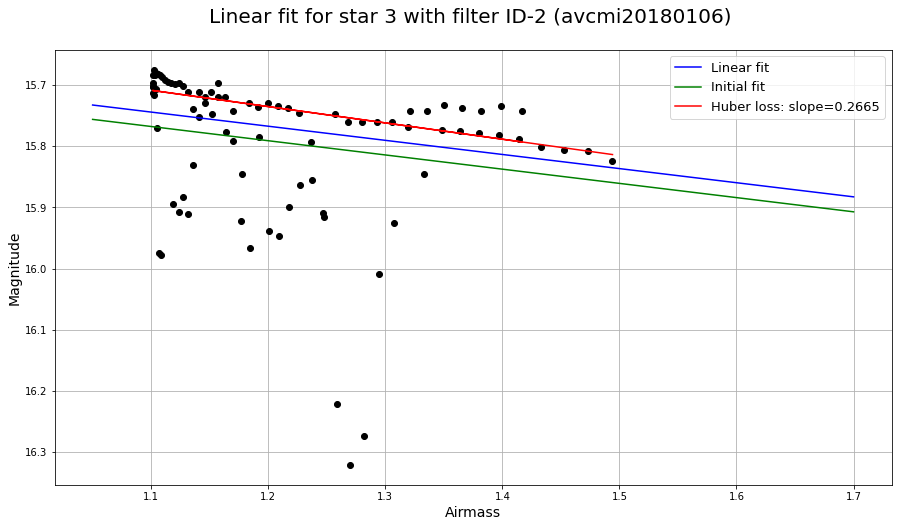

In [27]:
ID_1 = np.array(data['ID'])
airmass_1 = np.array(data['airmass'])
filt_1 = data['filt']
mag_obs_1 = np.array(data['mag_obs'])
mag_err_1 = np.array(data['mag_err'])

A = np.vander(airmass_1[(np.array(filt_1)==2) & (ID_1==3)], 2)
C = np.diag(mag_err_1[(np.array(filt_1)==2) & (ID_1==3)] * mag_err_1[(np.array(filt_1)==2) & (ID_1==3)])
ATA = np.dot(A.T, A/(mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)] / mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]**2))


# Fit curve with likelihood method

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma_square = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model)**2 / sigma_square + np.log(sigma_square))

np.random.seed(42)
nil = lambda *args: -log_likelihood(*args)
initial = np.array([0.2, 20, np.log(0.02)])
soln = minimize(nil, initial, args=(airmass_1[(np.array(filt_1)==2) & (ID_1==3)],
                                    mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)], 
                                    mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]))
mag_max_lik, b_max_lik, log_f_max_lik = soln.x
print("Maximum likelihood method:")
print("m: ", mag_max_lik)
print("b: ", b_max_lik)


plt.figure(figsize=(15,8))
plt.plot(airmass_1[(np.array(filt_1)==2) & (ID_1==3)], mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)], 'ko')
plt.gca().invert_yaxis()
xx = np.linspace(1.05, 1.7, 100)
yy = xx * w[0] + w[1]
yy2 = xx * mag_max_lik + b_max_lik

plt.plot(xx, yy, '-', color='b',label='Linear fit')
plt.plot(xx, yy2, '-', color='g',label='Initial fit')
plt.plot(test_x, predictions, 'r', label='Huber loss: slope='+
         str(round(np.polyfit(test_x, predictions,1)[0],4)))

plt.legend(fontsize=13)
plt.title('Linear fit for star 3 with filter ID-2 (avcmi20180106) \n',fontsize=20)
plt.xlabel('Airmass',fontsize=14)
plt.ylabel('Magnitude',fontsize=14)
plt.grid()

plt.savefig('Huber_loss.png')
plt.show()

6.42728


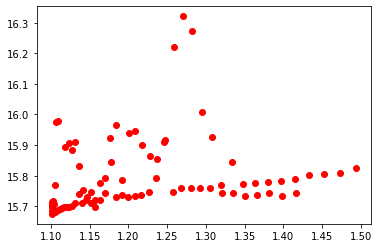

In [100]:
Q1 = data['mag_obs'].quantile(0.01)
Q3 = data['mag_obs'].quantile(0.99)
IQR = Q3 - Q1
print(IQR)

threshold = 1.5
outliers = data['mag_obs'][(data['mag_obs'] < Q1 - threshold * IQR) | (data['mag_obs'] > Q3 + threshold * IQR)]

data = data.drop(outliers.index)


airmass_1 = np.array(data['airmass'])
filt_1 = np.array(data['filt'])
mag_obs_1 = np.array(data['mag_obs'])
plt.plot(airmass_1[(filt_1==2) & (ID_1==3)], mag_obs_1[(filt_1==2) & (ID_1==3)], 'ro')



In [96]:
ID_1.shape

(2819,)

In [124]:
np.polyfit(test_x, predictions,1)[0]

0.2665198967149359

In [51]:
for i in range(2,5,1):
    y = mag_obs_1[(filt_1==i) & (ID_1==8)]
    x = airmass_1[(filt_1==i) & (ID_1==8)]

    x_scaler, y_scaler = StandardScaler(), StandardScaler()
    x_train = x_scaler.fit_transform(x[..., None])
    y_train = y_scaler.fit_transform(y[..., None])

    model = HuberRegressor(epsilon=1)
    model.fit(x_train, y_train.ravel())

    test_x = airmass_1[(filt_1==i) & (ID_1==8)]
    predictions = y_scaler.inverse_transform(
        model.predict(x_scaler.transform(test_x[..., None]))
    )
        
    print(round(np.polyfit(test_x, predictions,1)[0],4))

0.1066
0.2424
0.0679


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Maximum likelihood method:
m:  0.2310658526452475
b:  15.514426848152517


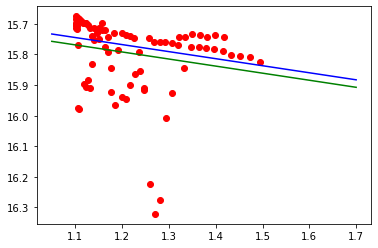

In [30]:
ID_1 = np.array(data['ID'])
airmass_1 = np.array(data['airmass'])
filt_1 = data['filt']
mag_obs_1 = np.array(data['mag_obs'])
mag_err_1 = np.array(data['mag_err'])

A = np.vander(airmass_1[(np.array(filt_1)==2) & (ID_1==3)], 2)
C = np.diag(mag_err_1[(np.array(filt_1)==2) & (ID_1==3)] * mag_err_1[(np.array(filt_1)==2) & (ID_1==3)])
ATA = np.dot(A.T, A/(mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)] / mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]**2))


# Fit curve with likelihood method

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma_square = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model)**2 / sigma_square + np.log(sigma_square))

np.random.seed(42)
nil = lambda *args: -log_likelihood(*args)
initial = np.array([0.2, 20, np.log(0.02)])
soln = minimize(nil, initial, args=(airmass_1[(np.array(filt_1)==2) & (ID_1==3)],
                                    mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)], 
                                    mag_err_1[(np.array(filt_1)==2) & (ID_1==3)]))
mag_max_lik, b_max_lik, log_f_max_lik = soln.x
print("Maximum likelihood method:")
print("m: ", mag_max_lik)
print("b: ", b_max_lik)


plt.figure()
plt.plot(airmass_1[(np.array(filt_1)==2) & (ID_1==3)], mag_obs_1[(np.array(filt_1)==2) & (ID_1==3)], 'ro')
plt.gca().invert_yaxis()
xx = np.linspace(1.05, 1.7, 100)
yy = xx * w[0] + w[1]
yy2 = xx * mag_max_lik + b_max_lik
plt.plot(xx, yy, '-', color='b')
plt.plot(xx, yy2, '-', color='g')
plt.show()
